# Mahalanobis distance
The idea:
- Mahalanobis "distance" or similarity is standard deviation extended to multiple variables
- Main idea of this script is to measure similarity of all locations in a given geotiff to a (small) group of known mineral occurences.
    - The similarity is measured compared to the averaged features of the mineral occurences, meaning that even the known mineral occurences do not get full similarity.

## Inputs:
Files that can be used for testing can be found here https://seafile.utu.fi/d/766d85c069a540cf9931/

Geotiff with different geophysical measurements in each band

Known mineral occurences: current testing implementation takes csv that contains values sampled from the Geotiff. However this is just for alpha testing. Further revisions should just ask a shapefile, geopackage or similar that has the locations of the known mineral occurences. Then the geotiff values at these locations should be sampled. This reduces user work considerably

## Outputs
printed: 
- multivariate normality test results
- possible warnings
- 2 Geotiffs, that have the same geographical extent as the original geotiff
    - Mahalanobis similarity in standard deviations. Because there are probably more than 2 variables, values over 2 are to be expected even for the known occurences.
    - P-values. Users should be noted that p-values close to 1 mean high confidence in similarity, while values close to 0 mean dissimilarity. This can be confusing as usually low p-values are considered "good"


Notes:
- feature importance should be determined beforehand, and only relevant features should be used for actual modelling
- Mahalanobis assumes that the variables have multivariate normal distribution. The user should be warned if the given data does not follow that distribution. Current implementation uses Henze-Zirkler test for testing. However, there is no one best way to test multivariate normality, so optimally multiple tests should be implemented.
- Acceptable p-value of the multivariate tests should be given as an option to the user.
- The results of the multivarie normality test(s) should be printed to the user in any case
- Similarity values are measured in standard deviations
- Because Mahalanobis is statistical test, it also creates probability values, which is very useful because there are usually not very many known mineral occurence.
- High p-value (close to 1) means that point is similar to average of known occurences with strong confidence
- low p-value (close to 0) means that the point is not similar to the average of known occurences
- There are multiple ways to create covariance matrix, and these should be given as options to the user. maximum likelihood estimation (MLE) is common, but not robust to noise. Minimum covariance determinant estimation (MCD) is more robust and should be a  default. Other possibilities could also be added in future

Author:
Iiro Seppä, University of Turku

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pingouin
import rasterio

import warnings

from sklearn.covariance import MinCovDet
from IPython.display import display

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [2]:
def calculate_mahalanobis(data_vector, mean_vector, cov):
    """ Calculates Mahalanobis distance 
    """
    difference = data_vector - mean_vector
    inv_cov = np.linalg.inv(cov)
    
    dot = np.dot(difference, inv_cov)
    mahalanobis = np.dot(dot, difference.T)
    return mahalanobis.diagonal()
def calculate_stats(data, mcd=True):
    """Calculates covariance matrix of the data. 
    """
    mean = np.mean(data, axis=0)
    
    if mcd:
        cov_obj = MinCovDet().fit(data)
        cov = cov_obj.covariance_
    else:
        cov = np.cov(np.transpose(data), dtype='float32')
    
    return mean, cov

def calculate_mahalanobis_p(mahalanobis, degrees_of_freedom):
    return 1 - sp.stats.chi2.cdf(mahalanobis, degrees_of_freedom)

def return_to_original_size(compressed_raster, raster_params, nodata):
    """ Adding the removed nodata values back to the array to get it into
    right geographical shape later.
    
    INPUTS
    
    compressed_raster: one dimensional array
    nodata_lengths: lengths of the consecutive nodata runs in the original (flattened) raster as 1d array
    realdata_lengths: same as above but for real data
    
    """
    nodata_lengths = raster_params['nodata_lengths']
    realdata_lengths = raster_params['realdata_lengths']
    consecutive_nodata_run_count = raster_params['nodata_lengths'].size
    consecutive_realdata_run_count = raster_params['realdata_lengths'].size
    first = raster_params['first_is_nan']
    last = raster_params['last_is_nan'] 
    true_size = raster_params['size']
    true_shape = raster_params['shape']
    
    dtype = compressed_raster.dtype
    output = np.empty(true_size, dtype=dtype)
    i = 0
    j = 0
    # Tested only for (first == True, last == True) and (first == False, last== False)
    if first:
        if last: # first and last value is nan
            for r in range(consecutive_nodata_run_count -1):
                nan_length = nodata_lengths[r]
                output[i:i +nan_length] = nodata
                i += nan_length
                real_length = realdata_lengths[r]
                output[i:i+real_length] = compressed_raster[j: j + real_length]
                i += real_length
                j += real_length
            nan_length = nodata_lengths[-1]
            output[i:i +nan_length] = nodata
        else: # first value is nan and last value is a real value
            for r in range(consecutive_nodata_run_count):
                nan_length = nodata_lengths[r]
                output[i:i +nan_length] = nodata
                i += nan_length
                real_length = realdata_lengths[r]
                output[i:i+real_length] = compressed_raster[j: j + real_length]
                i += real_length
                j += real_length
    else:
        if last: # first value is real and last is nan
            for r in range(consecutive_realdata_run_count):
                real_length = realdata_lengths[r]
                output[i:i+real_length] = compressed_raster[j: j + real_length]
                i += real_length
                j += real_length
                nan_length = nodata_lengths[r]
                output[i:i +nan_length] = nodata
                i += nan_length
        else: # first value is real and last is real
            for r in range(consecutive_nodata_run_count):
                real_length = realdata_lengths[r]
                output[i:i+real_length] = compressed_raster[j: j + real_length]
                i += real_length
                j += real_length
                nan_length = nodata_lengths[r]
                output[i:i +nan_length] = nodata
                i += nan_length
            real_length = realdata_lengths[-1]
            output[i:i+real_length] = compressed_raster[j: j + real_length]

    output = np.reshape (output, true_shape)
    
    return output

In [3]:
# Reading data of locations with known deposits to calculate the covariance

"""this csv is just for alpha testing. Further revisions should just ask a shapefile, 
geopackage or similar that has the locations of the known mineral occurences. 
Then the geotiff values at these locations should be sampled. This reduces user work considerably
"""
deposits_full = pd.read_csv("data/testing/cnn/iron_deposits.csv")

#Options
#Significance level
alpha = 0.05
# Minimum covariance determinant (MCD) or Maximum likelihood estimate (MLE)
mcd = True
# The spatial coordinates are not processed so they are dropped
deposits = deposits_full.drop(labels=['E', 'N'], axis=1)
display(deposits)
# Changing to numpy array
deposits = deposits.to_numpy(dtype="float32")
"""Testing multivariate normality. 
The assumption is that even though geological data of the area may not be normally distributed,
the known deposits would be
"""
print(deposits.shape)
henze_zirkler, hz_pval, hz_normal = pingouin.multivariate_normality(deposits, alpha=alpha)
print(f"henze_zirkler value: {henze_zirkler} , p-value:{hz_pval}")
if not hz_normal:
    warnings.warn(f"The given sample data does not follow multivariate normal distribution according to henze-zirkler test")
mean_vector, cov = calculate_stats(deposits, mcd=mcd)
deposit_mahalanobis = calculate_mahalanobis(deposits, mean_vector, cov)
print(mean_vector)
print(deposit_mahalanobis)
print(calculate_mahalanobis_p(deposit_mahalanobis, 9))

,EM_Inph,Em_Qd,EM_Ap_rs,EM_ratio,Rd_K,Rd_Th,Rd_TC,Rd_U,Mag_TMI,gw_hgt50
0,-408.969513,369.960022,1279.775146,-1.059486,2.209176,4.111344,7.256684,1.361351,2268.848145,2952.96
1,3889.745605,2384.806152,7.000539,1.817769,0.887854,4.090817,4.183869,0.832645,2813.121826,750.00
2,1468.369385,1285.413208,403.246338,1.034502,1.930971,6.688927,8.287006,1.834672,3587.031250,1364.75
3,537.748718,324.102142,86.599457,1.903474,1.682847,6.492664,7.283080,2.067703,5973.162598,1843.90
4,-6.511929,625.734375,1382.579956,0.025980,0.730828,0.083772,0.281035,0.198836,7332.366211,250.00
5,-435.950928,248.234833,1303.053223,-1.672447,1.687366,6.609815,6.947016,1.835323,572.300415,2865.70
6,-210.937698,1754.664917,913.758728,-0.309453,0.940562,4.096137,5.734356,3.155816,208.218918,390.50
7,-373.599243,440.641846,1576.765137,-1.192332,1.735671,4.458209,4.887394,1.324908,865.384277,3007.10
8,-885.269836,675.116272,1820.296997,-2.274024,1.852086,6.723588,6.873117,1.505029,847.251038,1321.00
9,619.958496,578.203674,312.966248,1.160073,1.389441,2.313290,4.138221,1.366957,3260.305664,570.10


(12, 10)
henze_zirkler value: 0.9786991646329657 , p-value:0.03146885065885932
[ 3.3019632e+02  8.2347589e+02  9.5380609e+02 -8.9218937e-02
  1.5212356e+00  4.5189056e+00  5.5104451e+00  1.4494576e+00
  3.3065264e+03  1.5559418e+03]
[ 9.42388352 10.52269774  8.83101694  8.85040068 10.99215756  9.32649795
 10.98883338 10.99967781  8.7792532  10.87122229 10.52795126  9.88641068]
[0.39910074 0.30984801 0.45301693 0.4511967  0.27624688 0.4076977
 0.27647513 0.27573102 0.4578957  0.28463943 0.30945677 0.35975902]


/tmp/ipykernel_5548/415363080.py:24: UserWarning: The given sample data does not follow multivariate normal distribution
  warnings.warn(f"The given sample data does not follow multivariate normal distribution")


In [4]:
# full area
test_data_path = "data/possible data/test/important_features.tif"

# Dictionary for holding the general parameters of the raster
raster_params = {}

# Extracting image and necessary information
raster = rasterio.open(test_data_path)
raster_params['nodata_value'] = raster.nodata
nodata_mask = raster.read_masks(1)
"""Changing the mask to reflect numpy convention instead of gdal.
Invalid entries have a value of 1, and valid have values of 0.
"""
nodata_mask[nodata_mask == 0] = 1
nodata_mask[nodata_mask == 255] = 0
raster_params['nodata_mask'] = nodata_mask

flat_nodata_mask = nodata_mask.flatten()
bool_flat_nodata_mask = flat_nodata_mask.astype(bool)

# Does the raster start with nodata
raster_params['first_is_nan'] = bool_flat_nodata_mask[0]
# Does the raster end with nodata
raster_params['last_is_nan'] = bool_flat_nodata_mask[-1]

""" Getting the consecutive lengths of nodata values in an array,
this is used to reconstuct the array back into georeferenced raster after processing.
implementation is from this stackoverflow post 
https://stackoverflow.com/questions/24342047
"""
raster_params['nodata_lengths'] = np.diff(np.where(np.concatenate(([bool_flat_nodata_mask[0]],
                                     bool_flat_nodata_mask[:-1] != bool_flat_nodata_mask[1:],
                                     [True])))[0])[::2]

# Getting the consecutive lengths of real values
bool_flat_realdata_mask = np.invert(bool_flat_nodata_mask)
raster_params['realdata_lengths'] = np.diff(np.where(np.concatenate(([bool_flat_realdata_mask[0]],
                                     bool_flat_realdata_mask[:-1] != bool_flat_realdata_mask[1:],
                                     [True])))[0])[::2]

raster_params['band_count'] = raster.count
degrees_of_freedom = raster_params['band_count'] -1
# Reading the first band as numpy array and saving useful values. Rasterio follows the gdal convention and starts band numbering from one.
band1 = raster.read(1)
raster_params['shape'] = band1.shape
raster_params['size'] = raster_params['shape'][0] * raster_params['shape'][1]


# Getting the count of real data
size = raster_params['size'] - np.count_nonzero(raster_params['nodata_mask'] == 1)

data = np.empty((size, raster_params['band_count']), dtype="float32")
for band_n in range(1, raster_params['band_count'] + 1):
    
    band = raster.read(band_n)
    # Changing the numpy array to masked array in order to handle nodata areas
    band = ma.array(band, mask=raster_params['nodata_mask'], dtype=np.float32)
    
    # Taking only the valid values
    flattened = ma.compressed(band)
    
    data[:,band_n-1] = flattened

raster.close()

In [5]:
""" Actually calculating the mahalanobis and it's p-value. 
This has to be done in chuncks with current implementation because memory use increases
exponentially with the size.
For example: an raster with dimensions 1361 x 1641 would have required 20 TiB of memory
"""
# Chunk size has been lightly performance tested, this seemed to be reasonable value while keeping sample sizes large enough
chunk_size = 500
iterations = data.shape[0] // chunk_size
mahalanobis = np.empty(data.shape[0], dtype='float32')
mahalanobis_p = np.empty(data.shape[0], dtype='float32')
for chunk in range(iterations):
    start_idx = chunk * chunk_size
    end_idx = ((chunk + 1) * chunk_size)
    data_chunk = np.copy(data[start_idx : end_idx,])
    mahalanobis[start_idx : end_idx]= calculate_mahalanobis(data_chunk, mean_vector, cov)
    mahalanobis_p[start_idx : end_idx] = calculate_mahalanobis_p(mahalanobis[start_idx : end_idx], degrees_of_freedom)
# The remainder is processed here. Not very elegant but works
start_idx = end_idx+ 1
data_chunk = data[start_idx :]
mahalanobis[start_idx:] = calculate_mahalanobis(data_chunk, mean_vector, cov)
mahalanobis_p[start_idx :] = calculate_mahalanobis_p(mahalanobis[start_idx :], degrees_of_freedom)

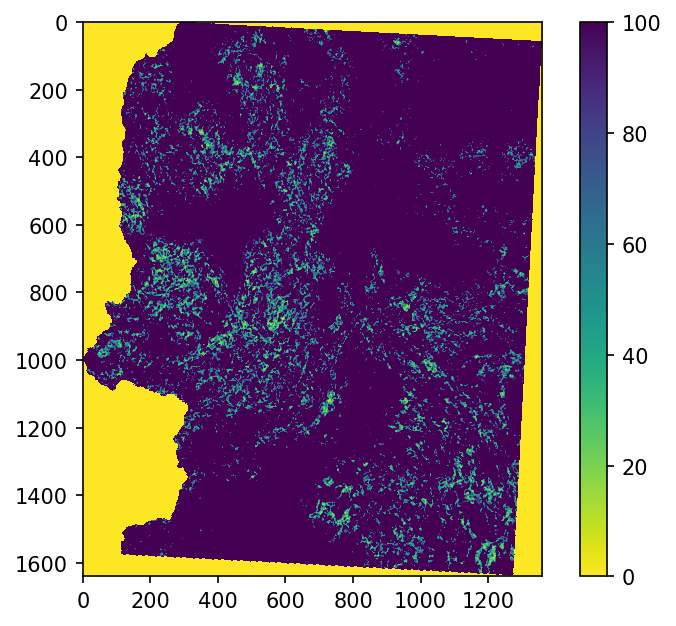

In [6]:
mahalanobis_raster = return_to_original_size(mahalanobis,
                                             raster_params, 
                                             raster_params['nodata_value'])

plt.imshow(mahalanobis_raster, vmin=0, vmax=100, cmap='viridis_r')
plt.colorbar()



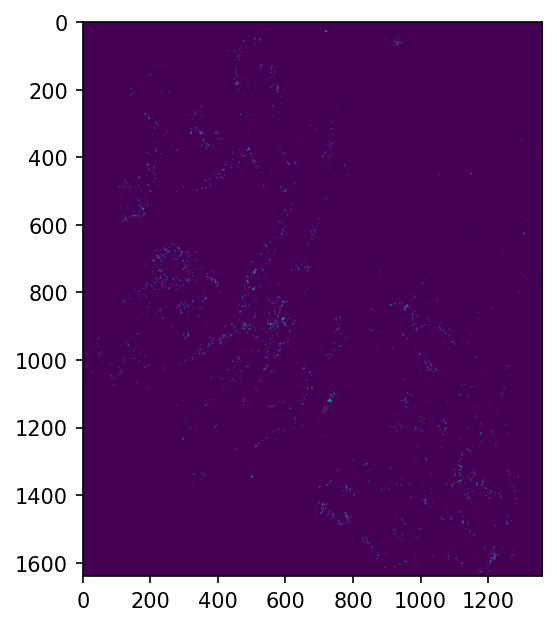

In [7]:
mahalanobis_p_raster = return_to_original_size(mahalanobis_p,
                                             raster_params, 
                                             raster_params['nodata_value'])

plt.imshow(mahalanobis_p_raster, vmin=0)

In [8]:
# writing the rasters
mahalanobis_path = f"data/testing/cnn/mahalanobis_MCD.tif"
with rasterio.open(mahalanobis_path,
                       "w",
                       driver="GTiff",
                       height=raster_params['shape'][0],
                       width=raster_params['shape'][1],
                       transform=raster.transform,
                       crs=raster.crs,
                       count=1,
                       mask=raster.read_masks(1),
                       nodata=raster_params['nodata_value'],
                       dtype=rasterio.float32) as dest:
            dest.write(mahalanobis_raster, indexes=1)
        
mahalanobis_p_path = f"data/testing/cnn/mahalanobis_p_MCD.tif" 
with rasterio.open(mahalanobis_p_path,
                       "w",
                       driver="GTiff",
                       height=raster_params['shape'][0],
                       width=raster_params['shape'][1],
                       transform=raster.transform,
                       crs=raster.crs,
                       count=1,
                       mask=raster.read_masks(1),
                       nodata=raster_params['nodata_value'],
                       dtype=rasterio.float32) as dest:
            dest.write(mahalanobis_p_raster, indexes=1)